f_inds (array([1]), array([   1,    2,    3, ..., 1998, 1999, 2000]))
[   1    2    3 ... 1998 1999 2000]
mag [0.0005 0.0005 0.0005 ... 0.     0.     0.    ]


C:\Users\R.J.P. Elfrink\AppData\Local\Temp\ipykernel_15592\2728019271.py:168: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(f, 20 * np.log10(np.abs(np.fft.fft(y))))


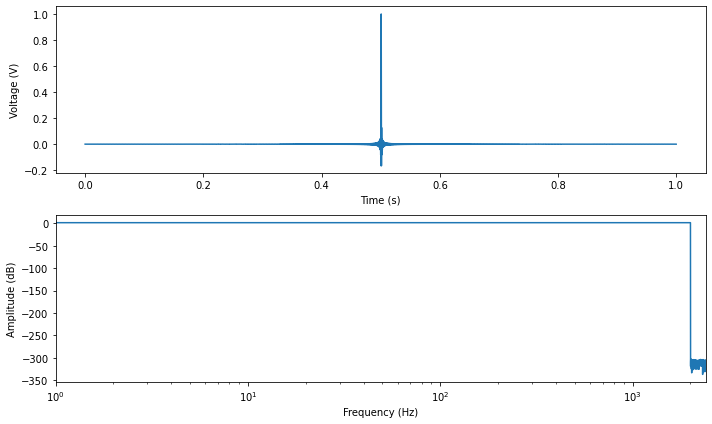

Crest factor: 36.02 dB


In [5]:
import numpy as np
import matplotlib.pyplot as plt

### Multisine: a function to generate a multi-sine signal with various
### properties, most notably phase distribution to minimise crest-factor.

# Author: Ben Holmes, adapted from a pseudonoise signal by Maarten van
# Walstijn.
# Date: 2019/01/09
# License: All rights reserved. (until the code is cleaned up)

# Inputs
# Required:
#   - frequencyLimits: the boundaries between which all sine components
#   will fall. Each sine will fall at multiples of f0=fs/Ns, which the
#   frequency limits will be rounded to.

#   - fs: sampling frequency.

#   - Ns: signal length in samples. It is recommended for multiple periods
#   of the signal to use repmat instead of a high value of Ns as the
#   Schroeder phases are slow to calculate, and increasing Ns will increase
#   the density of sine wave components.

# Other parameters:
#   - MagnitudeResponse: the amplitude of the sine wave components. Zero
#   values should be used for all magnitudes outside of the frequency
#   limits. Default is a flat response.

#   - PhaseResponse: Either a string to select "Schroeder",
#   "NormallyDistributed", or "ZeroValued" for the different phase options,
#   or a vector of the desired phase values. Default is "Schroeder".

#   - StartAtZero: a boolean flag to indicate whether to wrap the signal
#   such that it starts at the lowest gradient zero crossing. Default true.

#   - Normalise: a boolean flag that indicates whether to normalise the
#   signal to a peak value of 1. Default true.

#   - TimeDomain: a boolean flag that indicates whether to generate the
#   signal in the time domain or frequency domain. Default false. Used for
#   debugging the IFFT.

#   - InitialPhase: a scalar element that sets the first value of the
#   Schroeder phases, ignored for other settings. Default 0.

# Output
#   y: the multi-sine output signal.

def multisine(frequency_limits, fs, Ns, **kwargs):
    f0 = fs / Ns
    f_inds = np.arange(1, round(frequency_limits[0] / f0) + 1), np.arange(1, round(frequency_limits[1] / f0) + 1)
    print('f_inds',f_inds)

    if np.any(f_inds[1] > Ns / 2):
        raise ValueError('Frequency limits must be beneath Nyquist.')

    index_vector = np.arange(f_inds[0][0], f_inds[1][-1] + 1)
    NN = len(index_vector)
    print(index_vector)

    mag = kwargs.get('MagnitudeResponse', np.zeros(Ns))
    phase_response = kwargs.get('PhaseResponse', 'Schroeder')
    start_at_zero = kwargs.get('StartAtZero', True)
    normalise = kwargs.get('Normalise', True)
    time_domain = kwargs.get('TimeDomain', False)
    initial_phase = kwargs.get('InitialPhase', 0)

    if not np.any(mag):
        mag = np.zeros(Ns)
        mag[index_vector - 1] = 1.0 / len(index_vector)
        print('mag',mag)
    else:
        if len(mag) != Ns:
            raise ValueError('Magnitude response must be the same length as the desired signal.')

        mag = mag ** 2

        full_indices = np.arange(1, Ns + 1)
        zero_value_indices = np.setdiff1d(full_indices, index_vector)

        if np.any(mag[zero_value_indices]):
            print('Non-zero magnitude values present outside of frequency limits.')
            mag[zero_value_indices] = np.zeros_like(zero_value_indices)

        if np.sum(mag[index_vector - 1]) != 1:
            mag[index_vector - 1] = mag[index_vector - 1] / np.sum(mag[index_vector - 1])

    if isinstance(phase_response, str):
        if phase_response == 'Schroeder':
            phase = schroeder_phases(NN, Ns, index_vector, mag, initial_phase)
        elif phase_response == 'ZeroPhase':
            phase = np.zeros(Ns)
        elif phase_response == 'NormalDistribution':
            phase = np.random.randn(Ns)
        else:
            raise ValueError('Phase Response string must be Schroeder, ZeroPhase, or NormalDistribution.')
    else:
        phase = phase_response
        if np.any(phase.shape != (1, Ns)):
            raise ValueError('Phase response must be 1 x Ns.')

    if time_domain:
        y = np.zeros(Ns)
        t = np.arange(Ns) / fs
        for nn in range(NN):
            mm = index_vector[nn]
            y += np.sqrt(mag[mm - 1] / 2) * np.cos(2 * np.pi * f0 * (mm - 1) * t + phase[mm - 1])
        print(y)
    else:
        Y = np.sqrt(mag / 2) * np.exp(1j * phase)
        y = np.fft.ifft(force_fft_symmetry(Y)) * (Ns / 2)

    if normalise:
        y = y / np.max(np.abs(y))

    if start_at_zero:
        y_sign = y > 0
        zero_inds = np.where(y_sign[:-1] != y_sign[1:])[0]

        zero_grad = np.abs(y[zero_inds] - y[zero_inds + 1])
        min_ind = np.argmin(zero_grad)

        y_wrapped = np.concatenate((y[zero_inds[min_ind]:], y[:zero_inds[min_ind]]))
        y = y_wrapped

    return y


def schroeder_phases(n_components, Ns, index_vector, magnitude, p1):
    phase = np.zeros(Ns)

    phase[1] = p1

    for nn in range(2, n_components + 1):
        ll = np.arange(1, nn)
        phase[index_vector[nn - 1] - 1] = phase[1] - 2 * np.pi * np.sum((nn - ll) * magnitude[index_vector[ll] - 1])

    return phase


def force_fft_symmetry(X):
    Y = X.copy()
    X_start_flipped = np.flipud(X[1:np.floor_divide(len(X), 2) + 1])
    Y[np.ceil(len(X) / 2).astype(int):] = np.real(X_start_flipped) - 1j * np.imag(X_start_flipped)

    return Y

# Define the parameters
fs = 4800              # Sampling frequency
Ns = fs                 # Number of samples (for 1 second)

# Generate multisine between 1 Hz and 2 kHz
y = multisine([1, 2000], fs, Ns,PhaseResponse='ZeroPhase')

# Plot
t = np.arange(Ns) / fs
f = np.arange(Ns) * (fs / Ns)

plt.figure(figsize=(10, 6))

plt.subplot(211)
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')

plt.subplot(212)
plt.semilogx(f, 20 * np.log10(np.abs(np.fft.fft(y))))
plt.xlim([1, fs / 2])
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()
# Originally from matplotlib.mlab:
def rms_flat(a):
    """
    Return the root mean square of all the elements of *a*, flattened out.
    """
    return np.sqrt(np.mean(np.absolute(a)**2))


crest_factor = 20*np.log10(np.amax(abs(y))/rms_flat(y))
print('Crest factor: {0:.2f} dB'.format(crest_factor))